<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/CBAM_activation_on_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input,MaxPooling2D
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from visualize import plotImages, plotHistory, explainGradCam

In [2]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [3]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [4]:
def cbam(x,ratio=8):
    x = ChannelAttention(x,ratio)
    x = SpatialAttention(x)
    return x

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incomplete9ZQBLX/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incomplete9ZQBLX/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [9]:
ds_info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpdluur0d7tfds'),
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [10]:
ds_info.features['label'].names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

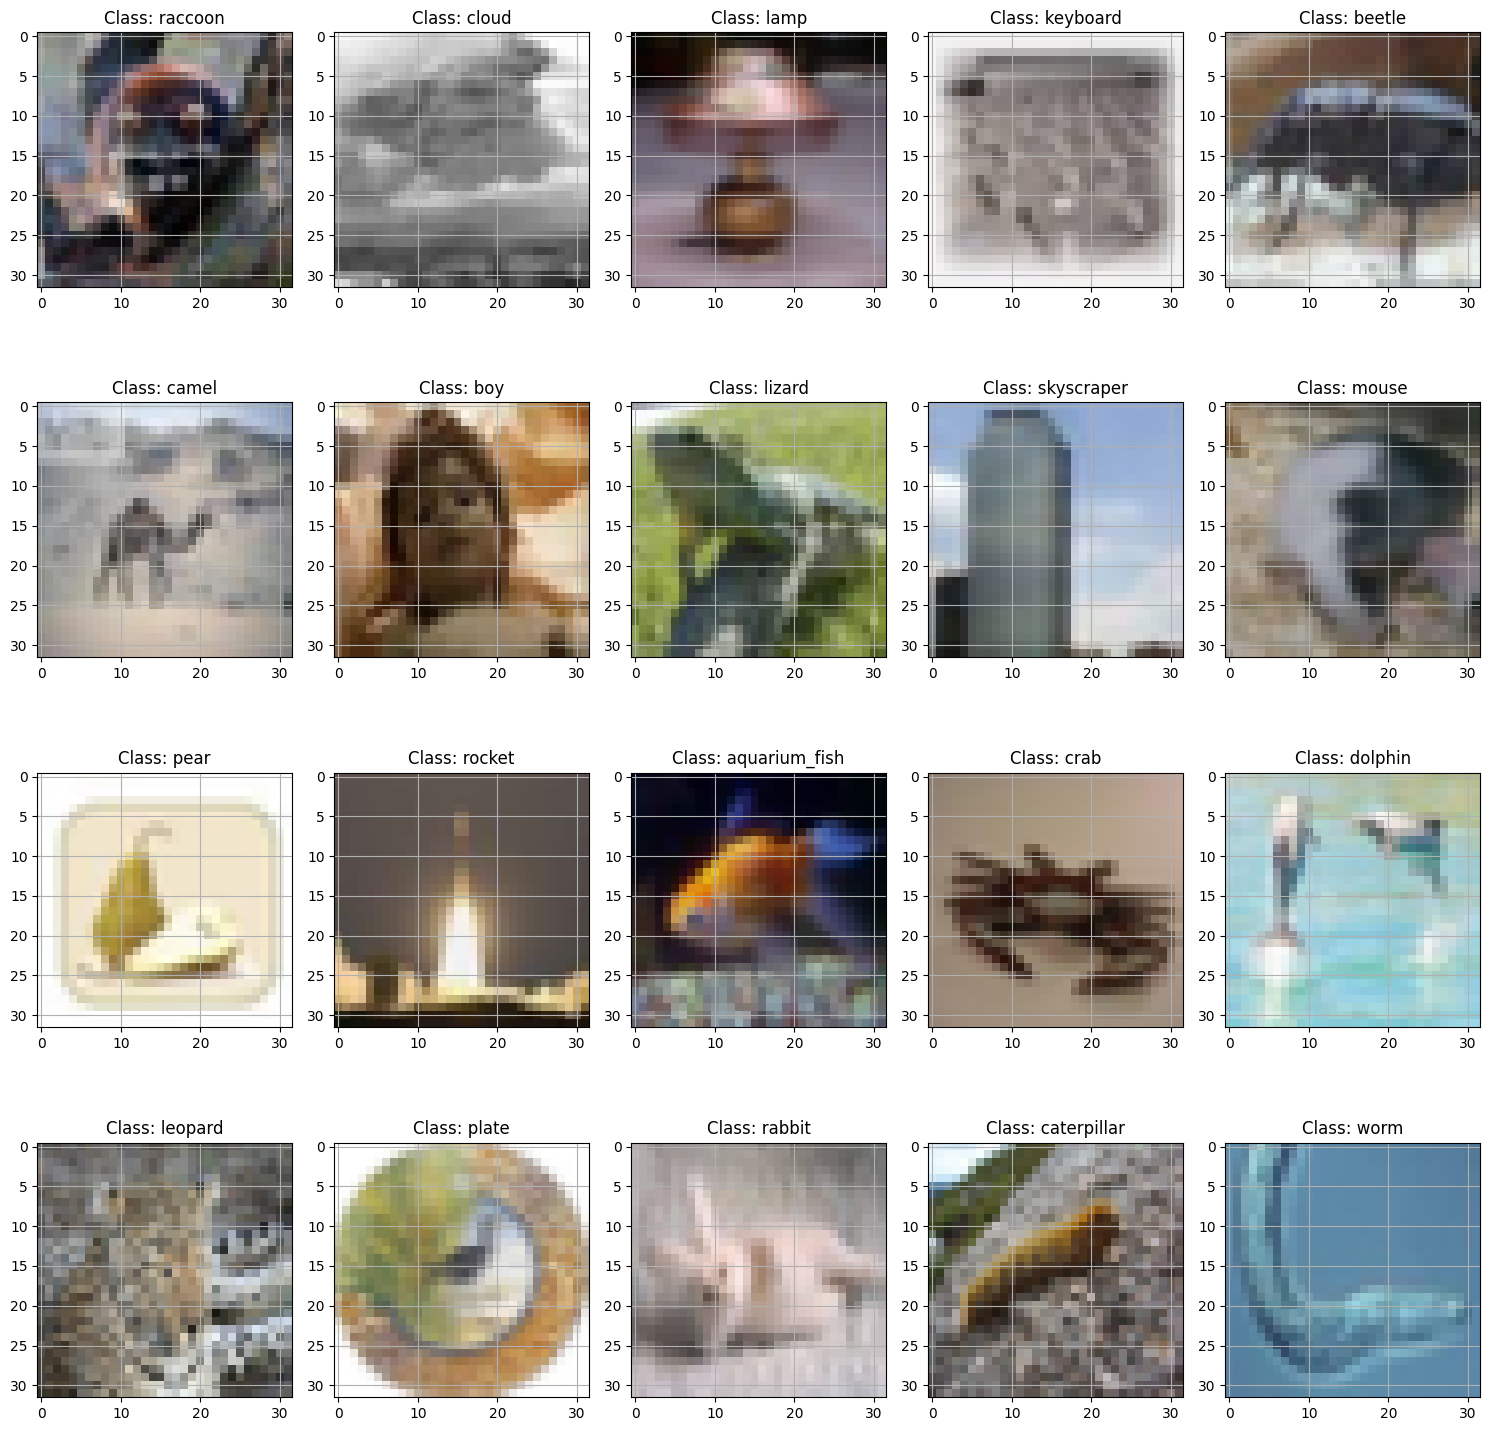

In [11]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

In [12]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [13]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Network without attention

In [15]:
simple_cnn_no_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [16]:
simple_cnn_no_attention.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

In [17]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [18]:
history = simple_cnn_no_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 24s 7ms/step - loss: 3.3063 - accuracy: 0.2014
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 2.4056 - accuracy: 0.3748
Epoch 3/20
1563/1563 [==============================] - 12s 8ms/step - loss: 2.0194 - accuracy: 0.4543
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.7760 - accuracy: 0.5114
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5915 - accuracy: 0.5583
Epoch 6/20
1563/1563 [==============================] - 12s 7ms/step - loss: 1.4361 - accuracy: 0.5953
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3084 - accuracy: 0.6271
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1867 - accuracy: 0.6543
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0802 - accuracy: 0.6827
Epoch 10/20
1563/1563 [==============================] - 11s 7ms/step - l

In [19]:
simple_cnn_with_cbam = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
  tf.keras.layers.BatchNormalization(),
  cbam(tf.keras.layers.Input(shape=ds_info.features['image'].shape)),  # Wrap input in Input layer
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
  tf.keras.layers.BatchNormalization(),
  cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 64))),  # Wrap in Input with appropriate shape
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
  tf.keras.layers.BatchNormalization(),
  cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 128))),  # Wrap in Input with appropriate shape
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

In [20]:
simple_cnn_with_cbam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 spatial_attention (Spatial  (None, 32, 32, 32)        0         
 Attention)                                                      
                                                      

In [21]:
simple_cnn_with_cbam.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [22]:
history = simple_cnn_with_cbam.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 15s 8ms/step - loss: 3.4120 - accuracy: 0.1823
Epoch 2/20
1563/1563 [==============================] - 12s 8ms/step - loss: 2.5115 - accuracy: 0.3497
Epoch 3/20
1563/1563 [==============================] - 12s 7ms/step - loss: 2.1046 - accuracy: 0.4389
Epoch 4/20
1563/1563 [==============================] - 13s 8ms/step - loss: 1.8612 - accuracy: 0.4926
Epoch 5/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6782 - accuracy: 0.5350
Epoch 6/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5314 - accuracy: 0.5707
Epoch 7/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4065 - accuracy: 0.6044
Epoch 8/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2917 - accuracy: 0.6320
Epoch 9/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1927 - accuracy: 0.6574
Epoch 10/20
1563/1563 [==============================] - 12s 8ms/step - l

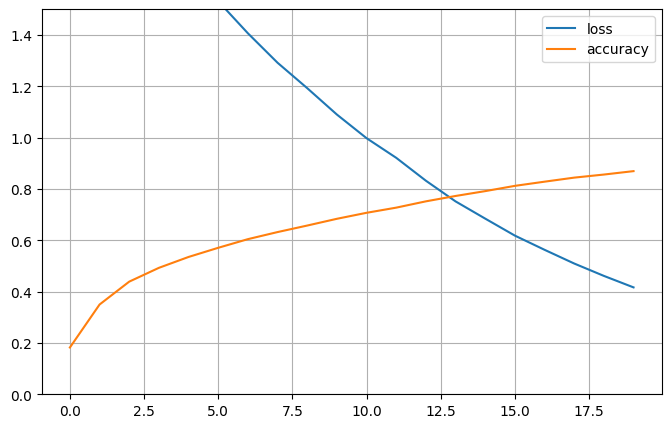

In [23]:
plotHistory(history)

In [24]:
print(f"Test accuracy: {simple_cnn_with_cbam.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 8ms/step - loss: 2.3538 - accuracy: 0.5133
Test accuracy: 0.5133000016212463


In [25]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00


In [26]:
from tf_explain.core.grad_cam import GradCAM

In [27]:
explainer = GradCAM()

In [28]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [29]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


Network with and without attention

1/1 [==============================] - 0s 17ms/step


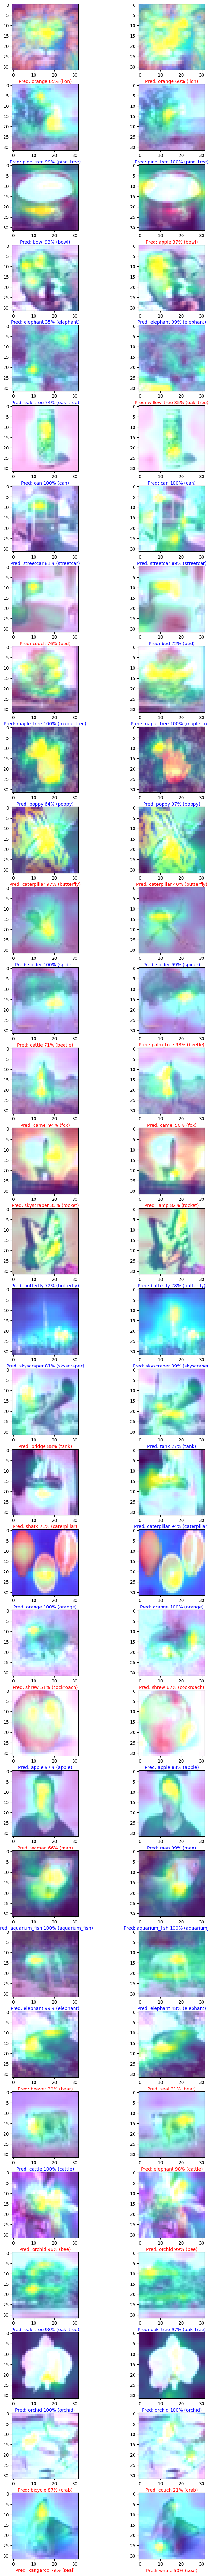

In [31]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img[None]),
               simple_cnn_with_cbam,
               simple_cnn_with_cbam.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1